# Predicting Alternative Energy Stock Movement with Logistic Regression

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

Set the year variable equal to the amount of trading days in a calendar year

In [5]:
YEAR = 252

## Load Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

In [7]:
data.index.names = ['symbol', 'date']

### Create Model Data

We seperate our target columns from the dataset and store them in an independent variable. We add the rest to a seperate variable and drop the dollar volume columns. 

In [8]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'Volume'], axis=1)

## Logistic Regression

### Define cross-validation parameters

This test used 63 trading days to train the model and then predicted 5-day returns for the following 10 days. As a result, we can use 20 10-day splits during the 2 years, starting in 2019.

In [9]:
train_period_length = 63
test_period_length = 10
n_splits = 20
lookahead = 5

cv = MultipleTimeSeriesCV(n_splits = n_splits,
                          test_period_length = test_period_length,
                          lookahead = lookahead,
                          train_period_length = train_period_length)

In [10]:
target = f'target_{lookahead}d'

In [11]:
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

1    2229
0    1698
Name: label, dtype: int64

In [12]:
Cs = np.logspace(-5, 5, 11)

In [13]:
cols = ['C', 'date', 'auc', 'ic', 'pval']

### Run cross-validation

In [14]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C = C, fit_intercept = True, random_state = 42, n_jobs = -1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    
    ics = aucs = 0
    start = time()
    coeffs = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X = X_train, y = y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
            
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score = y_score, y_true = y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted = y_score, C = C, actuals = actuals))
        
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis = 0).squeeze()

1e-05
	  2.2 | 010 |  13.54% |  57.98%
	  2.4 | 020 |  10.71% |  58.40%
0.0001
	  0.8 | 010 |  13.39% |  57.88%
	  1.6 | 020 |  10.96% |  58.45%
0.001
	  0.2 | 010 |  12.42% |  57.39%
	  0.4 | 020 |  12.69% |  59.09%
0.01
	  0.2 | 010 |  12.81% |  57.60%
	  0.4 | 020 |  16.93% |  60.96%
0.1
	  0.2 | 010 |  14.25% |  58.10%
	  0.4 | 020 |  21.38% |  63.00%
1.0
	  0.2 | 010 |  14.54% |  58.15%
	  0.5 | 020 |  21.39% |  62.80%
10.0
	  0.2 | 010 |  14.61% |  58.19%
	  0.6 | 020 |  21.29% |  62.72%
100.0
	  0.3 | 010 |  14.65% |  58.22%
	  0.5 | 020 |  21.26% |  62.71%
1000.0
	  0.3 | 010 |  14.66% |  58.22%
	  0.5 | 020 |  21.28% |  62.71%
10000.0
	  0.2 | 010 |  14.65% |  58.22%
	  0.5 | 020 |  21.27% |  62.71%
100000.0
	  0.2 | 010 |  14.65% |  58.22%
	  0.5 | 020 |  21.27% |  62.71%
CPU times: user 3.63 s, sys: 149 ms, total: 3.78 s
Wall time: 8.35 s


### Evaluate Results

In [15]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('data.h5', 'logistic/predictions')

In [16]:
log_scores = pd.read_hdf('data.h5', 'logistic/scores')

In [17]:
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       220 non-null    float64       
 1   date    220 non-null    datetime64[ns]
 2   auc     220 non-null    float64       
 3   ic      220 non-null    float64       
 4   pval    220 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 10.3 KB


In [19]:
def plot_ic_distribution(df, ax = None):
    if ax is not None:
        sns.distplot(df.ic, ax = ax)    
    else:
        ax = sns.distplot(df.ic)
        
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls = '--', c = 'k')
    ax.text(x=.05, y=.9, s = f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

We see that the **C** value corresponding to $10^{3}$ has the best information coefficent at roughly **22%**. This translates to a correct prediction nearly 60% of the time.

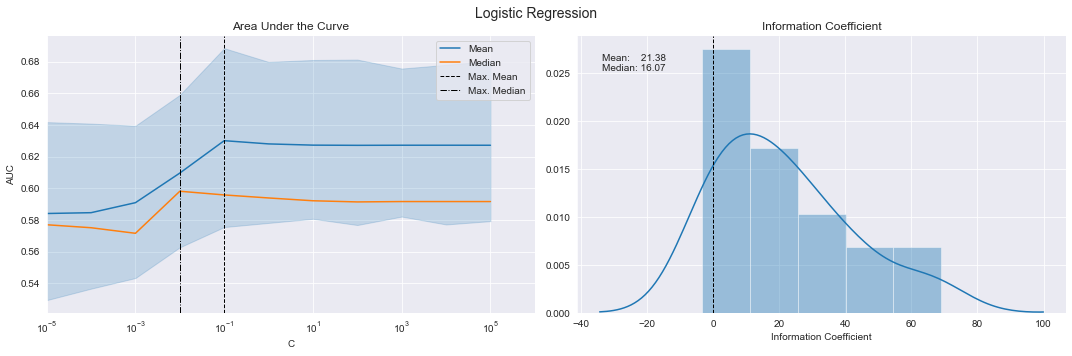

In [20]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x = 'C', y = 'auc', data = log_scores, estimator = np.mean, label = 'Mean', ax = axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx = True, ax = axes[0], label = 'Median', xlim = (10e-6, 10e5))

axes[0].axvline(best_auc, ls = '--', c = 'k', lw = 1, label = 'Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls = '-.', c = 'k', lw = 1, label = 'Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);